In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import math
import matplotlib.pyplot as plt
from importlib import reload

# Data processing

In [32]:
users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
ratings=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/ratings.dat',sep="::",names=['UserID','MovieID','Rating','Timestamp'])

<ipython-input-32-4c609c110fe4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
<ipython-input-32-4c609c110fe4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
<ipython-input-32-4c609c110fe4>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as r

Split train - test set

In [33]:
u=len(users)
m=max(movies["MovieID"])
r_train,r_test=train_test_split(ratings,test_size=0.1,stratify=ratings['UserID'])

r_train.head()

,UserID,MovieID,Rating,Timestamp
674729,4049,1197,5,965497695
805698,4823,2133,2,963174212
128726,835,2664,4,975361383
81823,543,2717,4,976119452
550272,3391,3145,5,967655785


# Item-item model


Utility matrix

In [34]:
user_item=np.full((m,u),np.nan)
for r in r_train.itertuples():
    user_item[r[2]-1][r[1]-1]=r[3]

user_item_test=np.full((m,u),np.nan)
for r in r_test.itertuples():
    user_item_test[r[2]-1][r[1]-1]=r[3]
user_item

array([[ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Similarity matrix

In [35]:
mean=np.nanmean(user_item,axis=1)
mean_user=np.nanmean(user_item,axis=0)
for i in range(m):
    user_item[i]=user_item[i]-mean[i]
    user_item_test[i] = user_item_test[i] - mean[i]

nan_cell=np.argwhere(np.isnan(user_item))

user_item=np.nan_to_num(user_item)

<ipython-input-35-66939538ae68>:1: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(user_item,axis=1)


In [36]:
nan_list=[[] for i in range(u)]
for cell in nan_cell:
    nan_list[cell[1]].append(cell[0])

In [37]:
def similarity(x,y):
    if np.dot(x,y)==0:
        return 0
    return np.dot(x,y)/math.sqrt(np.sum(x**2)*np.sum(y**2))

In [38]:
similarity_matrix=np.full((m,m),np.nan)
for movie_1 in range(m):
    for movie_2 in range(movie_1+1):
        res=similarity(user_item[movie_1],user_item[movie_2])
        similarity_matrix[movie_1][movie_2]=res
        similarity_matrix[movie_2][movie_1]=res

similarity_matrix

array([[ 1.        ,  0.09061235,  0.04300958, ...,  0.02531027,
         0.01195811,  0.03576232],
       [ 0.09061235,  1.        ,  0.03865755, ..., -0.01682697,
        -0.00796852,  0.00314799],
       [ 0.04300958,  0.03865755,  1.        , ...,  0.02360488,
         0.01931653,  0.02860138],
       ...,
       [ 0.02531027, -0.01682697,  0.02360488, ...,  1.        ,
         0.04836442,  0.03805426],
       [ 0.01195811, -0.00796852,  0.01931653, ...,  0.04836442,
         1.        ,  0.11376878],
       [ 0.03576232,  0.00314799,  0.02860138, ...,  0.03805426,
         0.11376878,  1.        ]])

Prediction

In [39]:
similarity_matrix=np.nan_to_num(similarity_matrix)
mean=np.nan_to_num(mean)

In [40]:
def predict(user,movie,k):
    copy=np.array(similarity_matrix[movie])

    np.delete(copy,nan_list[user])
    neighbor=(-copy).argsort()[1:k+1]
    similar=copy[neighbor]
    rate=user_item.T[user][neighbor]
    if np.sum(similar)!=0:
        return (rate@similar)/np.sum(np.abs(similar))
    return 0

In [41]:
def predict_matrix(k):
    matrix=user_item.copy()
    for r in r_test.itertuples():
        pred=predict(r[1]-1,r[2]-1,k)
        # matrix[r[2]-1][r[1]-1]=pred+mean[r[2]-1]
        matrix[r[2]-1][r[1]-1]=pred
    return matrix

# Evaluation

# Metric function

In [42]:
def RMSE(pred, test):
    pred=pred.T
    test=test.T
    rmse=0
    mae=0
    for user in range(u):
        e=pred[user]-test[user]
        rmse+=np.nanmean(np.square(e))
        mae+=np.nanmean(np.abs(e))
    return (rmse/u, mae/u)

In [43]:
def PrecisionAtK(Y,K):
    X=user_item_test.T.copy()
    Y=Y.T
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    precisionK=[]
    recallK=[]
    f1K=[]
    mapK=[]
    marK=[]
    for user in range(u):
        rcm = rcm_movie[user]
        rcm = rcm[np.argwhere(Y[user][rcm] > 0)]
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = np.intersect1d(rcm, rcm_test)
        rcm_test = rcm_test[np.argwhere(X[user][rcm_test] > 0)]
        rcm = rcm[:K]

        precision=np.in1d(rcm,rcm_test)
        recall=np.in1d(rcm_test,rcm)

        map=[]
        for k in range(len(rcm)):
            p = np.mean(precision[:k+1])*precision[k]
            if p>0:
                map.append(p)

        mar=[]
        for k in range(len(rcm_test)):
            r = np.mean(recall[:k+1])*recall[k]
            if r>0:
                mar.append(r)

        precision=np.mean(precision)
        recall=np.mean(recall)
        f1=0
        if precision + recall != 0:
            f1 = 2*precision*recall/(precision+recall)
        precisionK.append(precision)
        recallK.append(recall)
        f1K.append(f1)
        mapK.append(np.mean(map))
        marK.append(np.mean(mar))

    precisionK=np.nan_to_num(precisionK)
    recallK=np.nan_to_num(recallK)
    f1K=np.nan_to_num(f1K)
    mapK=np.nan_to_num(mapK)
    marK=np.nan_to_num(marK)

    return (np.mean(precisionK), np.mean(recallK), np.mean(f1K), np.mean(mapK), np.mean(marK))

In [44]:
def NDCG(Y,K):
    X=user_item_test.copy()
    for i in range(m):
        X[i] += mean[i]
    X=X.T
    Y=Y.T
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    ndcg=[]
    for user in range(u):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = rcm_movie[user][np.in1d(rcm_movie[user], rcm_test)]
        for i in range(len(rcm[:K])):
            dcg += (2**X[user][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**X[user][rcm_test[i]]-1)/math.log(i+2, 2)
        ndcg.append(dcg/idcg)
    return np.mean(ndcg)

# Test for number of neighbor

In [54]:
rmse = []
mae = []
precision = []
recall = []
f1 = []

iteration_list = [5,15,30,50,100]

for k in iteration_list:
    user_item = predict_matrix(k)
    e=RMSE(user_item, user_item_test)
    rmse.append(e[0])
    mae.append(e[1])

    metric=PrecisionAtK(user_item, 10000)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])

RMSE:  [0.8876055285289779, 0.8869562822370012, 0.8980236660928967, 0.9072748462224666, 0.918771529735926]
MAE:  [0.7443368756297427, 0.7469465055724787, 0.7529172558314865, 0.7573970067736312, 0.7629346195087682]


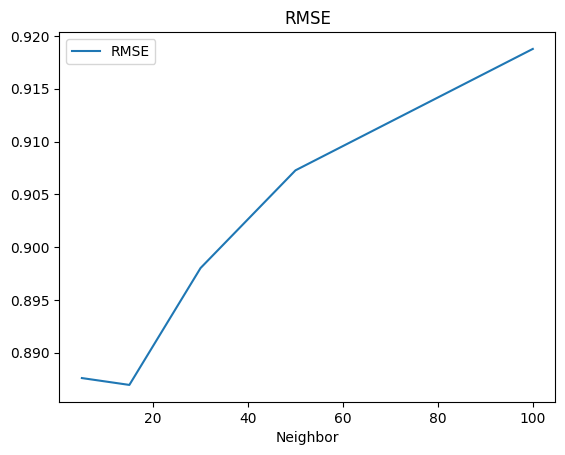

In [73]:
print("RMSE: ",rmse)
print("MAE: ",mae)
plt=reload(plt)
plt.plot(iteration_list, rmse, label='RMSE')
# plt.plot(iteration_list, mae, label='MAE')
plt.xlabel('Neighbor')
plt.title('RMSE')
plt.legend()
plt.show()

Precision:  [0.5544676277583301, 0.5762911443212794, 0.5893945424159448, 0.592994201930213, 0.5904872119712036]


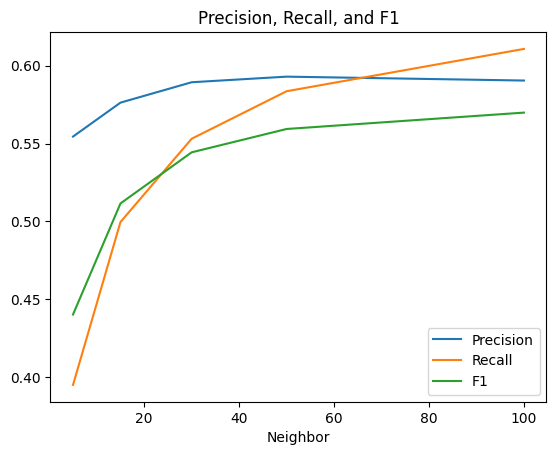

In [59]:
print("Precision: ",precision)
plt=reload(plt)
plt.plot(iteration_list, precision,label='Precision')
plt.plot(iteration_list, recall, label='Recall')
plt.plot(iteration_list, f1, label='F1')
plt.xlabel('Neighbor')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()

# Test for number of movie recommend

In [76]:
precision = []
recall = []
f1 = []
ndcg = []
map=[]
mar=[]
num_movie = [5,15,30,50,100]
user_item = predict_matrix(30)
for k in num_movie:
    e=RMSE(user_item, user_item_test)
    rmse.append(e[0])
    mae.append(e[1])

    metric=PrecisionAtK(user_item, k)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])
    map.append(metric[3])
    mar.append(metric[4])

    ndcg.append(NDCG(user_item, k))

Precision:  [0.5920309050772627, 0.5897603670244399, 0.589672267488396, 0.5896945852096453, 0.589666724427002]


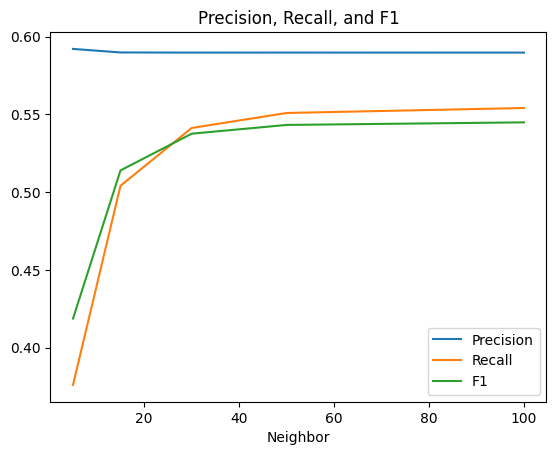

In [77]:
print("Precision: ",precision)
plt=reload(plt)
plt.plot(num_movie, precision,label='Precision')
plt.plot(num_movie, recall, label='Recall')
plt.plot(num_movie, f1, label='F1')
plt.xlabel('Neighbor')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()

MAP:  [0.6736083517292126, 0.6588150958204761, 0.656768532619689, 0.6564526953458736, 0.6564245308766211]
MAR:  [0.48764708127756123, 0.5994044298398383, 0.6341839149611478, 0.6437861038814879, 0.6468968594220602]
NDCG:  [0.7783385081833099, 0.8414434759465618, 0.8686009189795677, 0.8795240119063737, 0.884273760797651]


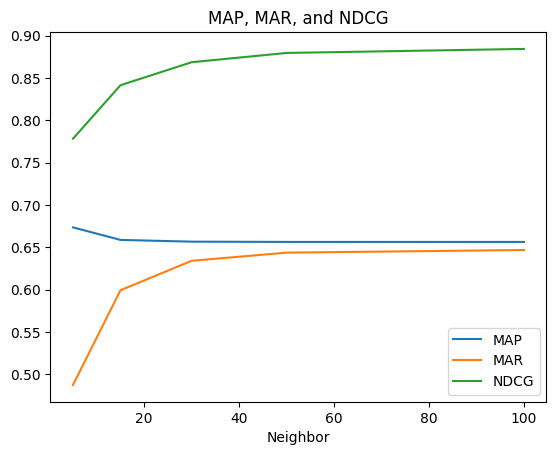

In [80]:
print("MAP: ",map)
print('MAR: ',mar)
print('NDCG: ', ndcg)
plt=reload(plt)
plt.plot(num_movie, map, label='MAP')
plt.plot(num_movie, mar, label ='MAR')
plt.plot(num_movie, ndcg, label ='NDCG')
plt.xlabel('Neighbor')
plt.title('MAP, MAR, and NDCG')
plt.legend()
plt.show()